In [1]:
from __future__ import print_function
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

1.11.0


In [2]:
tf.set_random_seed(2)

# Saving / Restoring  
    
    
## Saver and Session Object  
    
데이터를 파일 시스템에 영구적으로 저장하려면 TF는 **Saver** Object와 **Session** Object가 필요하다.  
     
**Saver** Object의 Constructor는 아래와 같다.  

```
__init__(
    var_list=None,
    reshape=False,
    sharded=False,
    max_to_keep=5,
    keep_checkpoint_every_n_hours=10000.0,
    name=None,
    restore_sequentially=False,
    saver_def=None,
    builder=None,
    defer_build=False,
    allow_empty=False,
    write_version=tf.train.SaverDef.V2,
    pad_step_number=False,
    save_relative_paths=False,
    filename=None
)
```  
    
- **var_list**는 파일시스템에 저장하는 변수의 리스트다
- 모든 변수를 저장할 수 있고, 몇몇의 변수만 저장할 수 있으며, 사용자가 직접 정의한 이름의 딕셔너리를 전달할 수도 있다.  
     
**Session** Constructor는 아래와 같다.
```
__init__(
    target='',
    graph=None,
    config=None
)
```  
    
- **target** : 분산 아키텍쳐 구조에서 어떤 계산을 처리할 때 사용한다. 특정 TF서버나 'target'을 정할 수 있다.
- **graph** : **Session** Object가 처리하는 그래프를 의미한다. 기본 파라미터는 default graph가 된다.
- **config** : **ConfigProto**를 입력으로 줄 수 있다. 자세한건 API document를 참조하자.
    
    
**Saver**는 **Graph**의 metadata와 **Variable** 데이터의 saving과 loading(restoring이라고 불린다)을 처리한다.
이를 위해서는 현재 Graph에서 평가될 수 있는 operation이 추가된다.  
    
     
**Saver**는 기본적으로 **default Graphe**를 처리하며, 모든 변수를 포함한다. 이는 사용자가 원하면, 따로 설정할 수 있다.

예제는 아래와 같다.
```
import tensorflow as tf

import os
dir = os.path.dirname(os.path.realpath(__file__))

# Currently, we are in the default graph scope

# Let's design some variables
v1 = tf.Variable(1. , name="v1")
v2 = tf.Variable(2. , name="v2")
# Let's design an operation
a = tf.add(v1, v2)

# We can check easily that we are indeed in the default graph
print(a.graph == tf.get_default_graph())
# -> True

# Let's create a Saver object
# By default, the Saver handles every Variables related to the default graph
all_saver = tf.train.Saver() 
# But you can precise which vars you want to save (as a list) and under which name (with a dict)
v2_saver = tf.train.Saver({"v2": v2}) 


# By default the Session handles the default graph and all its included variables
with tf.Session() as sess:
  # Init v1 and v2   
  sess.run(tf.global_variables_initializer())
  # Now v1 holds the value 1.0 and v2 holds the value 2.0
  # and we can save them
  all_saver.save(sess, dir + '/data-all')
  # or saves only v2
v2_saver.save(sess, dir + '/data-v2')
```
     
     
**Saver** Object를 통해서 저장하게되면, 해당 폴더에는 3가지 파일이 저장되고, `checkpoint`file이 생긴다.  
(자세한 내용은 따로 언급하겠다.)  
    
     
단순하게, 
- **.data**파일에는 weight파일이.  
- **.meta**파일에는 graph와 metadata파일이  
저장된다고 이해하면 된다.  
     
     
> **Saver**와 **Session**을 연결할 때, **Graph**가 **variables**을 포함하는지 확인해야한다.
> 아래 예제를 확인하자
    
```
import tensorflow as tf

g = tf.Graph()
with g.as_default():
    v1 = tf.Variable(5., dtype=tf.float32)
print(v1.graph == g)
# -> True
print(v1.graph == tf.get_default_graph())
# -> False

# The saver does not care in which part of the code it is constructed when given a list of variables
saver = tf.train.Saver([v1])

with tf.Session() as sess: 
    # The session handles the default graph which is NOT "g"
    sess.run(tf.global_variables_initializer())

    # This fails because "v1" is not in the default graph
saver.save(sess, 'test')
```
    
    

In [3]:
(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32).reshape(-1, 784)
x_test = (x_test/255).astype(np.float32).reshape(-1, 784)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

In [4]:
# Declare Input Node
x = tf.placeholder(dtype=tf.float32)
y = tf.placeholder(dtype=tf.int32)

# Declare parameter
layer1_weights = tf.Variable(initial_value=tf.truncated_normal([784, 500]) , dtype=tf.float32)
layer2_weights = tf.Variable(initial_value=tf.truncated_normal([500, 200]) , dtype=tf.float32)
layer3_weights = tf.Variable(initial_value=tf.truncated_normal([200, 10]) , dtype=tf.float32)

# build graph
feature1 = tf.matmul(x, layer1_weights)
activation1 = tf.tanh(feature1)
feature2 = tf.matmul(activation1, layer2_weights)
activation2 = tf.tanh(feature2)
score = tf.matmul(activation2, layer3_weights)

prediction = tf.argmax(input = score, axis=1)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=score)

In [6]:
opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer = opt.minimize(loss)

# TensorBoard
softmaxLoss = tf.summary.scalar(name='softmax_loss', tensor=loss)
train_writer = tf.summary.FileWriter('./graphs/low-level/train_mnist_dnn', graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter('./graphs/low-level/val_mnist_dnn', graph=tf.get_default_graph())

saver = tf.train.Saver()

# Hyper Parameter
epoch = 100
total_bar_length = tqdm_notebook(range(epoch))
batch_size=1024
total_step = int(x_train.shape[0] / batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_loss_hist = []
val_loss_hist = []

for i in total_bar_length:
    avg_train_loss = 0   
    avg_val_loss = 0 
    
    val_loss = 0
    
    train_loss_sum = 0    
    val_loss_sum = 0
    
    for step in range(total_step):
            batch_indices = np.random.choice(range(x_train.shape[0]), size=batch_size, replace=False)

            batch_xs = x_train[batch_indices]
            batch_ys = y_train[batch_indices]
            
            val_indices = np.random.choice(range(x_val.shape[0]), size=batch_size, replace=False)
            
            val_xs = x_val[val_indices]
            val_ys = y_val[val_indices]

            _, train_loss = sess.run([optimizer, loss], feed_dict={x:batch_xs, y:batch_ys})
            
            val_loss = sess.run(fetches = loss, feed_dict={x:val_xs, y:val_ys})
            
            avg_train_loss += train_loss / total_step
            avg_val_loss += val_loss / total_step
        
    train_loss_hist.append(avg_train_loss)
    val_loss_hist.append(val_loss)
    
    train_loss_sum = sess.run(softmaxLoss, feed_dict={x:batch_xs, y:batch_ys})
    val_loss_sum = sess.run(fetches = softmaxLoss, feed_dict={x:val_xs, y:val_ys})

    train_writer.add_summary(train_loss_sum, global_step = i)
    val_writer.add_summary(val_loss_sum, global_step = i)
        
train_writer.close()
val_writer.close()

global_step = tf.train.get_global_step()
saver.save(sess, './mnist', global_step=global_step)

print("train finished")

HBox(children=(IntProgress(value=0), HTML(value='')))


train finished


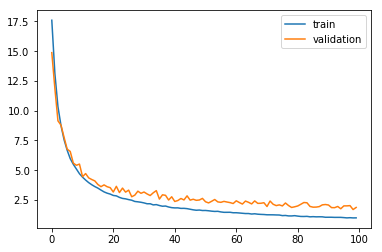

In [7]:
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist, label="validation")
plt.legend()
plt.show()

In [8]:
yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

acc : 82.65%


## Restoring operations and other metadata